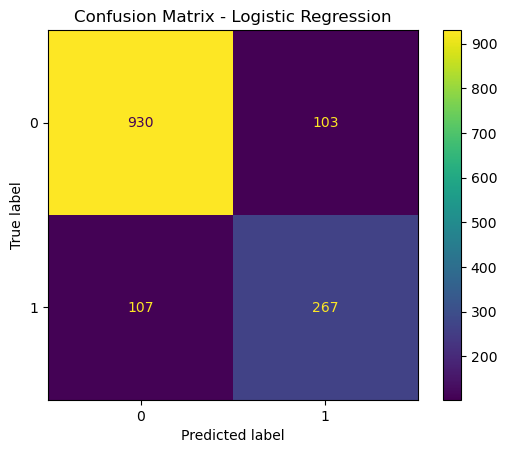

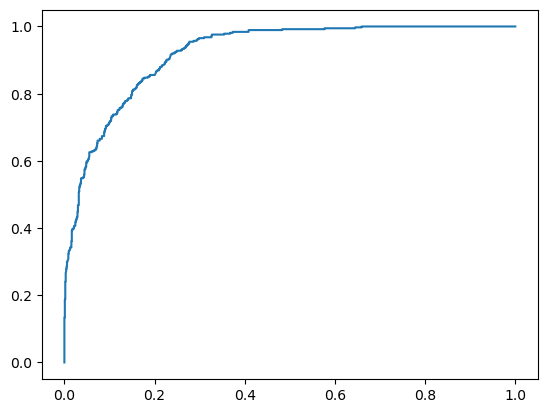

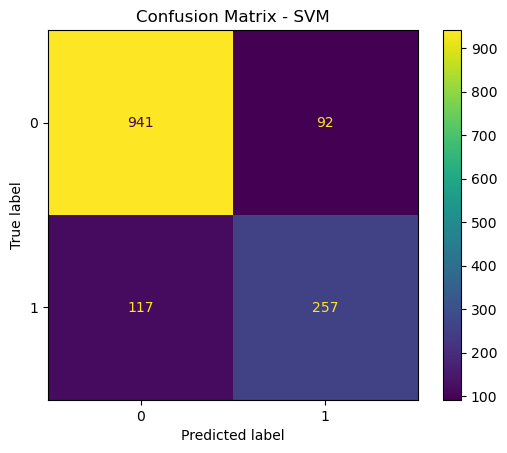

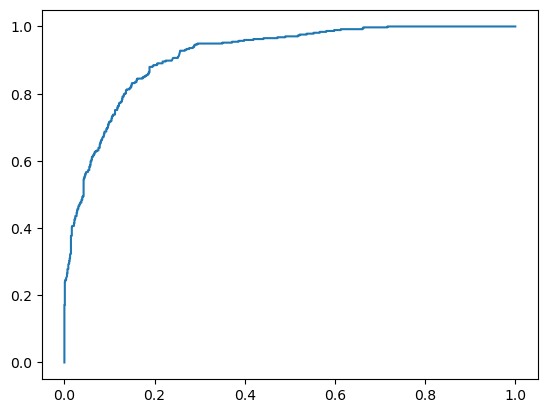

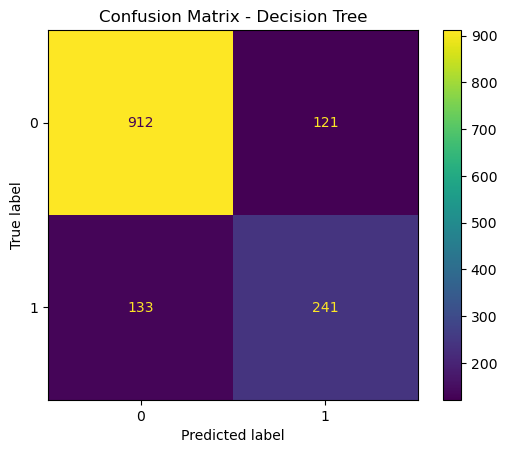

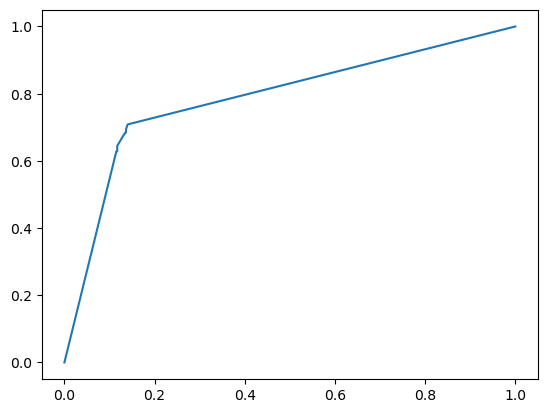

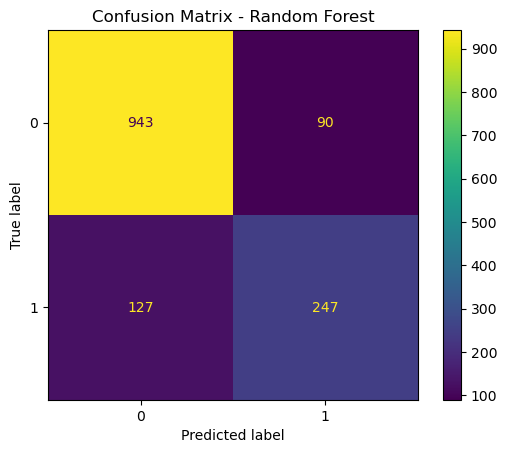

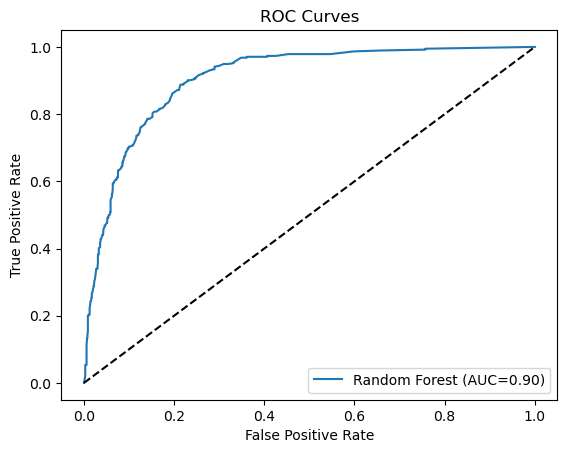

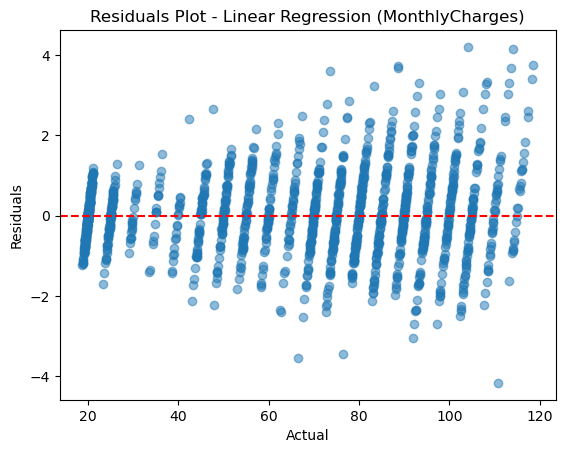

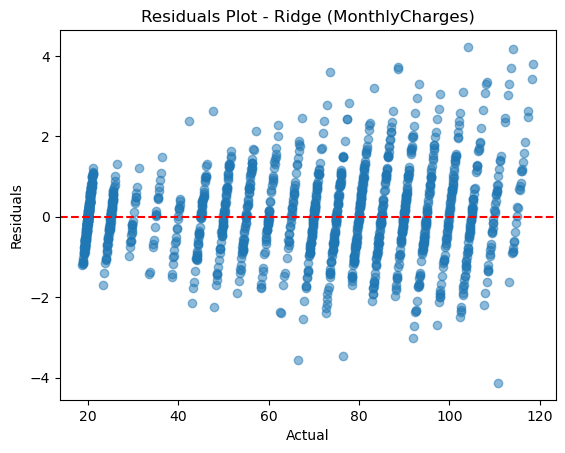

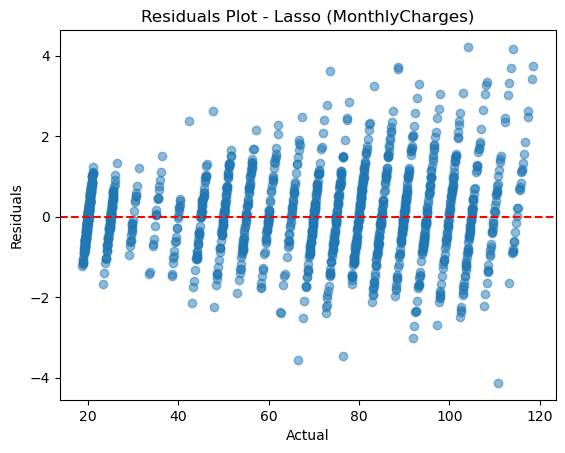

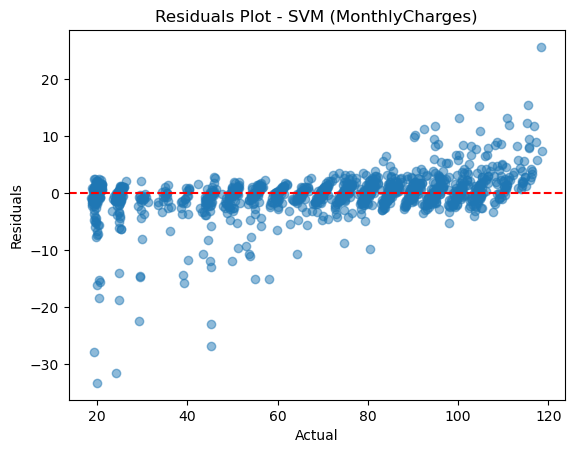

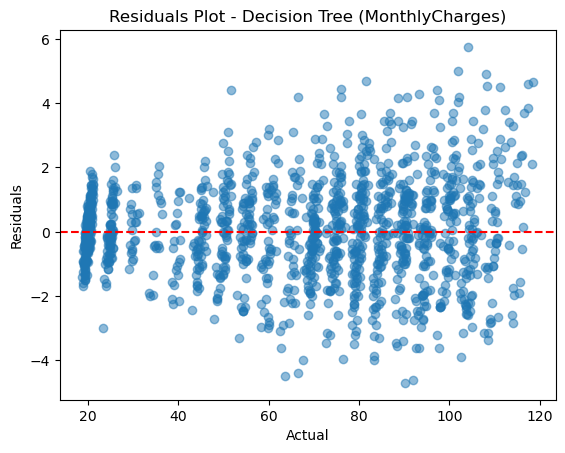

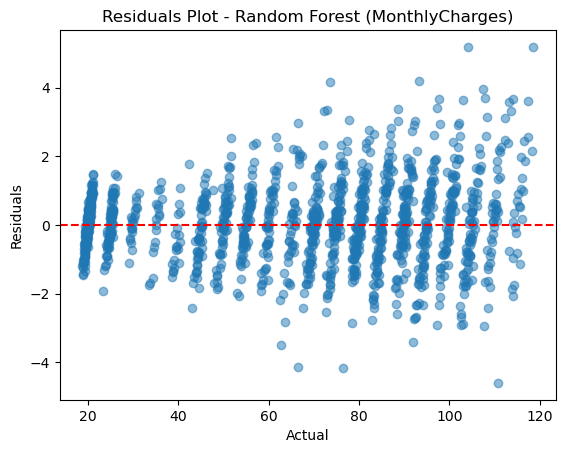

Classification Results:
                 Model  Accuracy  Precision    Recall  F1-Score   ROC-AUC
0  Logistic Regression  0.850746   0.721622  0.713904  0.717742  0.921493
1                  SVM  0.851457   0.736390  0.687166  0.710927  0.914358
2        Decision Tree  0.819474   0.665746  0.644385  0.654891  0.787384
3        Random Forest  0.845771   0.732938  0.660428  0.694796  0.904700

Regression Results:
               Model       MAE      RMSE        R2     CV_R2
0  Linear Regression  0.784876  1.039918  0.998776  0.998829
1              Ridge  0.784851  1.040380  0.998775  0.998831
2              Lasso  0.784276  1.039384  0.998778  0.998832
3                SVM  1.845151  3.516733  0.986006  0.986197
4      Decision Tree  1.166950  1.515206  0.997402  0.997505
5      Random Forest  0.861835  1.147343  0.998510  0.998571


In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay, roc_curve,
    mean_absolute_error, mean_squared_error, r2_score
)

# Models
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

# =====================
# Load and preprocess data
# =====================

df = pd.read_excel("02 Churn-Dataset.xlsx", sheet_name="01 Churn-Dataset")

# Drop customerID
if "customerID" in df.columns:
    df.drop(columns=["customerID"], inplace=True)

# Convert TotalCharges to numeric
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df.dropna(inplace=True)  # drop rows with missing TotalCharges

# Encode target for classification
le = LabelEncoder()
df["Churn"] = le.fit_transform(df["Churn"])  # Yes=1, No=0

# Feature engineering: count number of subscribed services
service_cols = ["PhoneService", "MultipleLines", "OnlineSecurity", "OnlineBackup",
                "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies"]

df["service_count"] = df[service_cols].apply(lambda row: sum(row != 'No'), axis=1)

# Separate features and targets
X = df.drop(columns=["Churn", "MonthlyCharges", "TotalCharges"])
y_class = df["Churn"]
y_reg_monthly = df["MonthlyCharges"]

# Identify categorical & numerical columns
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()
num_cols = X.select_dtypes(exclude=["object"]).columns.tolist()

# Preprocessor: OneHot for categoricals + Scale numerics
preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(drop="first"), cat_cols),
    ("num", StandardScaler(), num_cols)
])

# =====================
# Classification Models
# =====================

classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM": SVC(probability=True),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier()
}

class_results = []

for name, model in classifiers.items():
    pipe = Pipeline([
        ("preprocess", preprocessor),
        ("model", model)
    ])

    X_train, X_test, y_train, y_test = train_test_split(X, y_class, test_size=0.2, random_state=42, stratify=y_class)
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:,1] if hasattr(pipe["model"], "predict_proba") else None

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan

    class_results.append([name, acc, prec, rec, f1, auc])

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

    # ROC Curve
    if y_proba is not None:
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.2f})")

plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.show()

class_results_df = pd.DataFrame(class_results, columns=["Model", "Accuracy", "Precision", "Recall", "F1-Score", "ROC-AUC"])

# =====================
# Regression Models (Only MonthlyCharges)
# =====================

regressors = {
    "Linear Regression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.001),
    "SVM": SVR(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor()
}

reg_results = []

for name, model in regressors.items():
    pipe = Pipeline([
        ("preprocess", preprocessor),
        ("model", model)
    ])

    X_train, X_test, y_train, y_test = train_test_split(X, y_reg_monthly, test_size=0.2, random_state=42)
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    # Cross-validation R2
    cv_r2 = cross_val_score(pipe, X, y_reg_monthly, cv=5, scoring='r2').mean()

    # Metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    reg_results.append([name, mae, rmse, r2, cv_r2])

    # Residual Plot
    plt.scatter(y_test, y_test - y_pred, alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel("Actual")
    plt.ylabel("Residuals")
    plt.title(f"Residuals Plot - {name} (MonthlyCharges)")
    plt.show()

reg_results_df = pd.DataFrame(reg_results, columns=["Model", "MAE", "RMSE", "R2", "CV_R2"])

# =====================
# Final Results Tables
# =====================
print("Classification Results:")
print(class_results_df)

print("\nRegression Results:")
print(reg_results_df)


Input Features (X):

Demographics: gender, SeniorCitizen, Partner, Dependents, etc.

Services: PhoneService, InternetService, OnlineBackup, TechSupport, etc.

Contract/billing: Contract, PaperlessBilling, PaymentMethod, tenure.

Engineered feature: service_count.

Outputs:

Classification Output → Churn (binary: 0 = No, 1 = Yes).

Regression Output → MonthlyCharges (continuous numeric).
